**Extraction des données**

In [2]:
# extraction des données du dossier zip :
import tarfile

# remplace "fichier.tar.gz" par le chemin de ton fichier
with tarfile.open("aclImdb_v1.tar.gz", "r:gz") as archive:
    archive.extractall("data")  # décompresse tous les fichiers dans "data"
    print(archive.getnames())  # Liste des fichiers extraits

/tmp/ipykernel_1088/738913304.py:6: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  archive.extractall("data")  # décompresse tous les fichiers dans "data"
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



**Imports nécessaires**

In [3]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Création des datasets de train et test**

In [4]:
# version fonction

def create_datasets(dataset_type, polarity, base_path="data/aclImdb"):
    """
    Charge les reviews et les URLs correspondantes à partir des fichiers.
    
    :param dataset_type: 'train' ou 'test'
    :param polarity: 'pos' ou 'neg'
    :param base_path: Chemin de base vers les données (par défaut: "dossier_de_sortie/aclImdb")
    :return: DataFrame fusionné contenant les avis, les notes et les URLs associées
    """
    # chemins d'accès
    review_path = os.path.join(base_path, dataset_type, polarity)
    url_file = os.path.join(base_path, dataset_type, f"urls_{polarity}.txt")

    # chargement des fichiers texte et stockage dans une liste
    data = []
    for fichier in os.listdir(review_path):
        if fichier.endswith(".txt"):  
            chemin_fichier = os.path.join(review_path, fichier)
            with open(chemin_fichier, "r", encoding="utf-8") as f:
                contenu = f.read()
            data.append((fichier, contenu))

    # conversion en dataframe
    df_reviews = pd.DataFrame(data, columns=["fichier", "review"])
    df_reviews[["id_review", "note"]] = df_reviews["fichier"].str.replace(".txt", "", regex=False).str.split("_", expand=True)
    df_reviews = df_reviews.drop("fichier", axis=1)

    # ajout des urls pour chaque review
    df_urls = pd.read_csv(url_file, header=None, names=['url'])
    df_urls['id_imdb_movie'] = df_urls['url'].str.extract(r'(tt\d+)')
    merged_df = pd.concat([df_reviews, df_urls], axis=1)

    return merged_df


merged_test_neg = create_datasets(dataset_type="test", polarity="neg")
merged_test_pos = create_datasets(dataset_type="test", polarity="pos")
merged_train_neg = create_datasets(dataset_type="train", polarity="neg")
merged_train_pos = create_datasets(dataset_type="train", polarity="pos")

In [5]:
print(len(pd.unique(merged_test_neg['id_imdb_movie']))) # nombre de films dans la moitié négative de la base test
len(merged_test_neg) # nombre de reviews

3016


12500

In [6]:
# Création des datasets de test et train complets par merge des datasets de test/train pos et neg
test = pd.concat([merged_test_pos, merged_test_neg], ignore_index=True)
train = pd.concat([merged_train_pos, merged_train_neg], ignore_index=True)

In [7]:
print(len(pd.unique(test['id_imdb_movie']))) # nombre de films dans la base test
len(test) # nombre de reviews

3581


25000

In [9]:
print(len(pd.unique(train['id_imdb_movie']))) # nombre de films dans la base test
len(train) # nombre de reviews

3456


25000

In [10]:
# version shuffled ?
test_mix = test.sample(frac=1, random_state=42).reset_index(drop=True)
train_mix = train.sample(frac=1, random_state=42).reset_index(drop=True)
test_mix.head()

,review,id_review,note,url,id_imdb_movie
0,Liv Tyler. Liv Tyler. Liv Tyler. Yeah it's har...,11870,8,http://www.imdb.com/title/tt0077699/usercomments,tt0077699
1,This was not a good movie!! Why do you people ...,12195,1,http://www.imdb.com/title/tt0463903/usercomments,tt0463903
2,After reading the terrible reviews of this mov...,7278,7,http://www.imdb.com/title/tt0182576/usercomments,tt0182576
3,This film was basically set up for failure by ...,3325,1,http://www.imdb.com/title/tt0367623/usercomments,tt0367623
4,"""Sex and the City"" has some great things going...",7763,1,http://www.imdb.com/title/tt0202382/usercomments,tt0202382


**Observation des données**

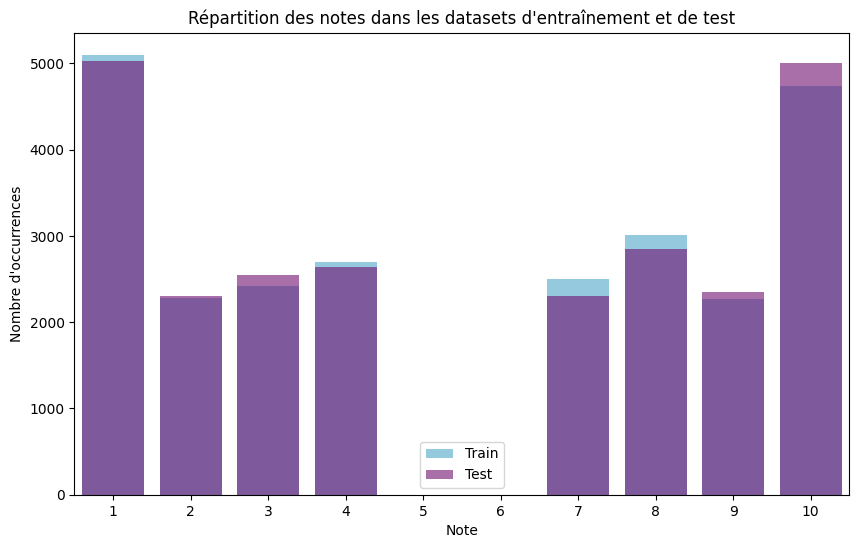

In [11]:
# Répartition des ratings

plt.figure(figsize=(10, 6))

# Distribution du train set
sns.countplot(x="note", data=train_mix, color="skyblue", label="Train", order=range(1, 11))

# Distribution du test set
sns.countplot(x="note", data=test_mix, color="purple", label="Test", order=range(1, 11), alpha=0.6)

plt.xlabel("Note")
plt.ylabel("Nombre d'occurrences")
plt.title("Répartition des notes dans les datasets d'entraînement et de test")
plt.legend()
plt.show()

In [12]:
# Recodages des labels test

test_mix['note'] = test_mix['note'].astype(int)

# sentiment en binaire
test_mix['note_bin'] = test_mix['note'].apply(lambda x: 0 if x <= 4 else (1 if x >= 7 else x))

# sentiment plus précis
mapping = {
    1: 'Very Negative', 2: 'Very Negative',
    3: 'Negative', 4: 'Negative',
    7: 'Positive', 8: 'Positive', 
    9: 'Very Positive', 10: 'Very Positive'
}
test_mix['note_prec'] = test_mix['note'].replace(mapping)

# modification des urls, la terminaison 'usercomments' ne sert pas
test_mix['url'] = test_mix['url'].str.replace('usercomments', '', regex=False)
test_mix['url'] = test_mix['url'].str.replace('http://', 'https://', regex=False)

test_mix.head(10)

,review,id_review,note,url,id_imdb_movie,note_bin,note_prec
0,Liv Tyler. Liv Tyler. Liv Tyler. Yeah it's har...,11870,8,https://www.imdb.com/title/tt0077699/,tt0077699,1,Positive
1,This was not a good movie!! Why do you people ...,12195,1,https://www.imdb.com/title/tt0463903/,tt0463903,0,Very Negative
2,After reading the terrible reviews of this mov...,7278,7,https://www.imdb.com/title/tt0182576/,tt0182576,1,Positive
3,This film was basically set up for failure by ...,3325,1,https://www.imdb.com/title/tt0367623/,tt0367623,0,Very Negative
4,"""Sex and the City"" has some great things going...",7763,1,https://www.imdb.com/title/tt0202382/,tt0202382,0,Very Negative
5,I found this movie on Netflix and had to add i...,648,8,https://www.imdb.com/title/tt0124901/,tt0124901,1,Positive
6,The story of a little girl who was driven once...,2006,10,https://www.imdb.com/title/tt0902306/,tt0902306,1,Very Positive
7,It's funny... one day before i have seen this ...,8024,2,https://www.imdb.com/title/tt0808151/,tt0808151,0,Very Negative
8,"Once again, there's dastardly government agenc...",12199,7,https://www.imdb.com/title/tt0088583/,tt0088583,1,Positive
9,Each frame in the movie is a lesson to new dir...,6571,10,https://www.imdb.com/title/tt0218839/,tt0218839,1,Very Positive


In [13]:
# Recodages des labels train

train_mix['note'] = train_mix['note'].astype(int)

# sentiment en binaire
train_mix['note_bin'] = train_mix['note'].apply(lambda x: 0 if x <= 4 else (1 if x >= 7 else x))

# sentiment plus précis
mapping = {
    1: 'Very Negative', 2: 'Very Negative',
    3: 'Negative', 4: 'Negative',
    7: 'Positive', 8: 'Positive', 
    9: 'Very Positive', 10: 'Very Positive'
}
train_mix['note_prec'] = train_mix['note'].replace(mapping)

# modification des urls, la terminaison 'usercomments' ne sert pas
train_mix['url'] = train_mix['url'].str.replace('usercomments', '', regex=False)
train_mix['url'] = train_mix['url'].str.replace('http://', 'https://', regex=False)

train_mix.head(10)

,review,id_review,note,url,id_imdb_movie,note_bin,note_prec
0,Walt Disney & his 9 Old Men put their own 1950...,2881,8,https://www.imdb.com/title/tt0071583/,tt0071583,1,Positive
1,The Class is a comedy series that portrays a b...,4353,4,https://www.imdb.com/title/tt0291502/,tt0291502,0,Negative
2,I went into this movie perhaps a bit jaded by ...,5029,8,https://www.imdb.com/title/tt0284690/,tt0284690,1,Positive
3,The 1960's were a time of change and awakening...,5582,3,https://www.imdb.com/title/tt0066836/,tt0066836,0,Negative
4,This thought long lost flick sometimes comes a...,1206,4,https://www.imdb.com/title/tt0156789/,tt0156789,0,Negative
5,To all the haters out there: condemning a TV s...,6981,9,https://www.imdb.com/title/tt0024727/,tt0024727,1,Very Positive
6,"The basic storyline here is, Aditiya (Kumar) i...",1833,10,https://www.imdb.com/title/tt0095655/,tt0095655,1,Very Positive
7,Beginning with its long opening shot of seemin...,3013,2,https://www.imdb.com/title/tt0164052/,tt0164052,0,Very Negative
8,Ingrid Bergman is a temporarily impoverished P...,6436,10,https://www.imdb.com/title/tt0070723/,tt0070723,1,Very Positive
9,"Movie ""comedies"" nowadays are generally 100 mi...",1080,9,https://www.imdb.com/title/tt0819765/,tt0819765,1,Very Positive


In [14]:
test_mix.to_csv("test_mix.csv", index=True)  # enregistrement du dataset de test (shuffled)

In [15]:
train_mix.to_csv("train_mix.csv", index=True)  # enregistrement du dataset de train (shuffled)

In [16]:
test_mix = pd.read_csv('test_mix.csv')
test_mix.columns

Index(['Unnamed: 0', 'review', 'id_review', 'note', 'url', 'id_imdb_movie',
       'note_bin', 'note_prec'],
      dtype='object')

In [17]:
train_mix = pd.read_csv('train_mix.csv')
train_mix.columns

Index(['Unnamed: 0', 'review', 'id_review', 'note', 'url', 'id_imdb_movie',
       'note_bin', 'note_prec'],
      dtype='object')

In [ ]:
# à faire :
# 1) la moyenne des notes sur chaque film, la variance et l'écart-type => est-ce que les reviews sont très contrastées sur chaque film ?
# 2) nombre de reviews par film en moyenne (vérifier qu'on est pas à plus de 30 pour chaque, mais c'est quoi la répartition exacte ? car il n'y a pas 30 reviews par film)
# 3) appliquer le modèle BERT pour constater un haut niveau d'accuracy

In [18]:
# 1) contraste des notes sur chaque film

# Variance per movie
rating_variance = train_mix.groupby('id_imdb_movie')['note'].var()

# Drop NaNs (movies with only one review will have NaN variance)
#rating_variance = rating_variance.dropna()

# Average variance
avg_variance = rating_variance.mean()

print(f"Average variance in ratings per movie: {avg_variance:.2f}")
print(rating_variance.describe())

Average variance in ratings per movie: 4.20
count    2793.000000
mean        4.195470
std         5.188806
min         0.000000
25%         1.000000
50%         1.900000
75%         6.000000
max        40.500000
Name: note, dtype: float64


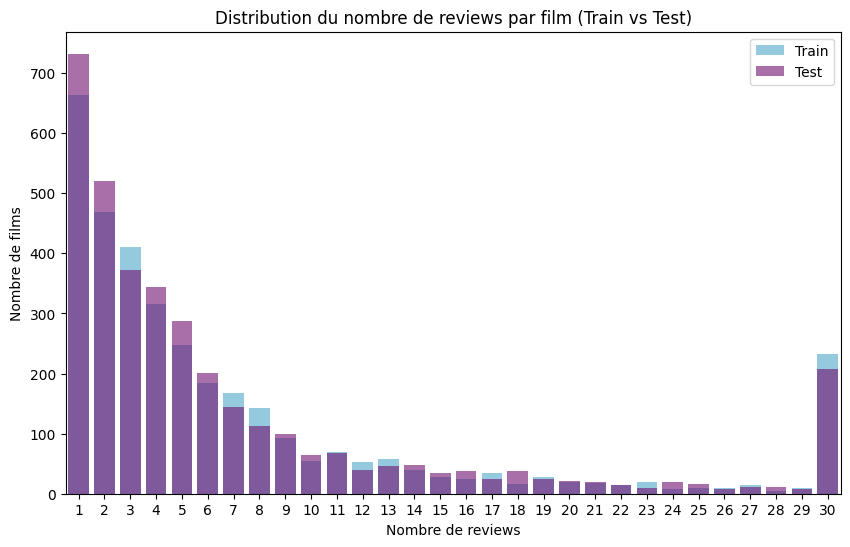

In [19]:
# 2) number of reviews per movie
# Nombre de reviews par film dans chaque set
train_review_counts = train_mix['id_imdb_movie'].value_counts().value_counts().sort_index()
test_review_counts = test_mix['id_imdb_movie'].value_counts().value_counts().sort_index()

# Tracer les deux distributions superposées
plt.figure(figsize=(10, 6))
sns.barplot(x=train_review_counts.index, y=train_review_counts.values, color='skyblue', label='Train')
sns.barplot(x=test_review_counts.index, y=test_review_counts.values, color='purple', alpha=0.6, label='Test')

# Mise en forme
plt.title('Distribution du nombre de reviews par film (Train vs Test)')
plt.xlabel('Nombre de reviews')
plt.ylabel('Nombre de films')
plt.legend()
plt.show()

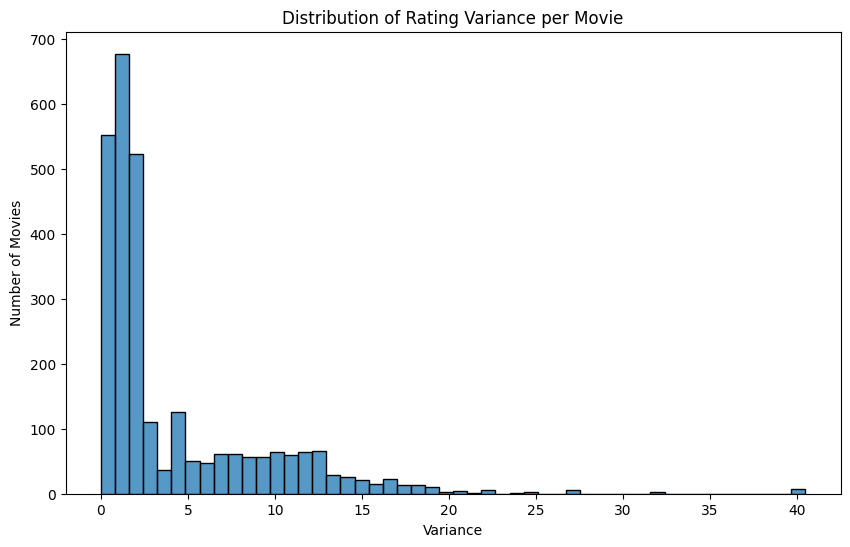

In [20]:
# Distribution des variances 
plt.figure(figsize=(10, 6))
sns.histplot(rating_variance, bins=50)
plt.title('Distribution of Rating Variance per Movie')
plt.xlabel('Variance')
plt.ylabel('Number of Movies')
plt.show()